In [1]:
import sys, torch
sys.modules['torch'].__dict__['__autoreload__'] = False
print(torch.cuda.is_available())
print(torch.version.cuda)
# Auto load python files
%load_ext autoreload
%autoreload 2

True
12.1


In [2]:
import open3d as o3d
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import json
from pandaset.geometry import lidar_points_to_ego

from src.download import data_download
from src.utils import load_dataset
from src.preprocess import filter_data
from src.EDA import run_eda, show_pcd_example
from src.datasets import PointNeXtDataset



Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [ ]:
# Replace with your Kaggle credentials if want to run the downloader. May use environment variable during the interview
kaggle_username = 'your_kaggle_username'                       #Replace with your Kaggle user name
kaggle_key = 'your_kaggle_key'   #Replace with your Kaggle API

# Set download=True to download
data_download(kaggle_username,kaggle_key , dest_path="./data/pandaset",download=False)

Already downloaded, no need to download again


In [4]:
# Load PandaSet LiDAR + semantic labels using the official devkit
lidar_data, segmantic_labels, lidar_poses = load_dataset()

Loading scene 001. Number of frames: 80
Loading scene 002. Number of frames: 80
Loading scene 003. Number of frames: 80
Loading scene 005. Number of frames: 80
Loading scene 011. Number of frames: 80
Loading scene 013. Number of frames: 80
Loading scene 015. Number of frames: 80
Loading scene 016. Number of frames: 80
Loading scene 017. Number of frames: 80
Loading scene 019. Number of frames: 80
Loading scene 021. Number of frames: 80
Loading scene 023. Number of frames: 80
Loading scene 024. Number of frames: 80
Loading scene 027. Number of frames: 80
Loading scene 028. Number of frames: 80
Loading scene 029. Number of frames: 80
Loading scene 030. Number of frames: 80
Loading scene 032. Number of frames: 80
Loading scene 033. Number of frames: 80
Loading scene 034. Number of frames: 80
Loading scene 035. Number of frames: 80
Loading scene 037. Number of frames: 80
Loading scene 038. Number of frames: 80
Loading scene 039. Number of frames: 80
Loading scene 040. Number of frames: 80


In [5]:
#Check for any empty frame (lidar,labels), and check for data and label mismatch
data, labels, poses = filter_data(lidar_data, segmantic_labels, lidar_poses)

Removed invalid frames (empty or mismatched).
Total valid frames: 2400


In [6]:
# class mapping provided in the data
with open("classes.json", "r") as f:
    class_map = json.load(f)

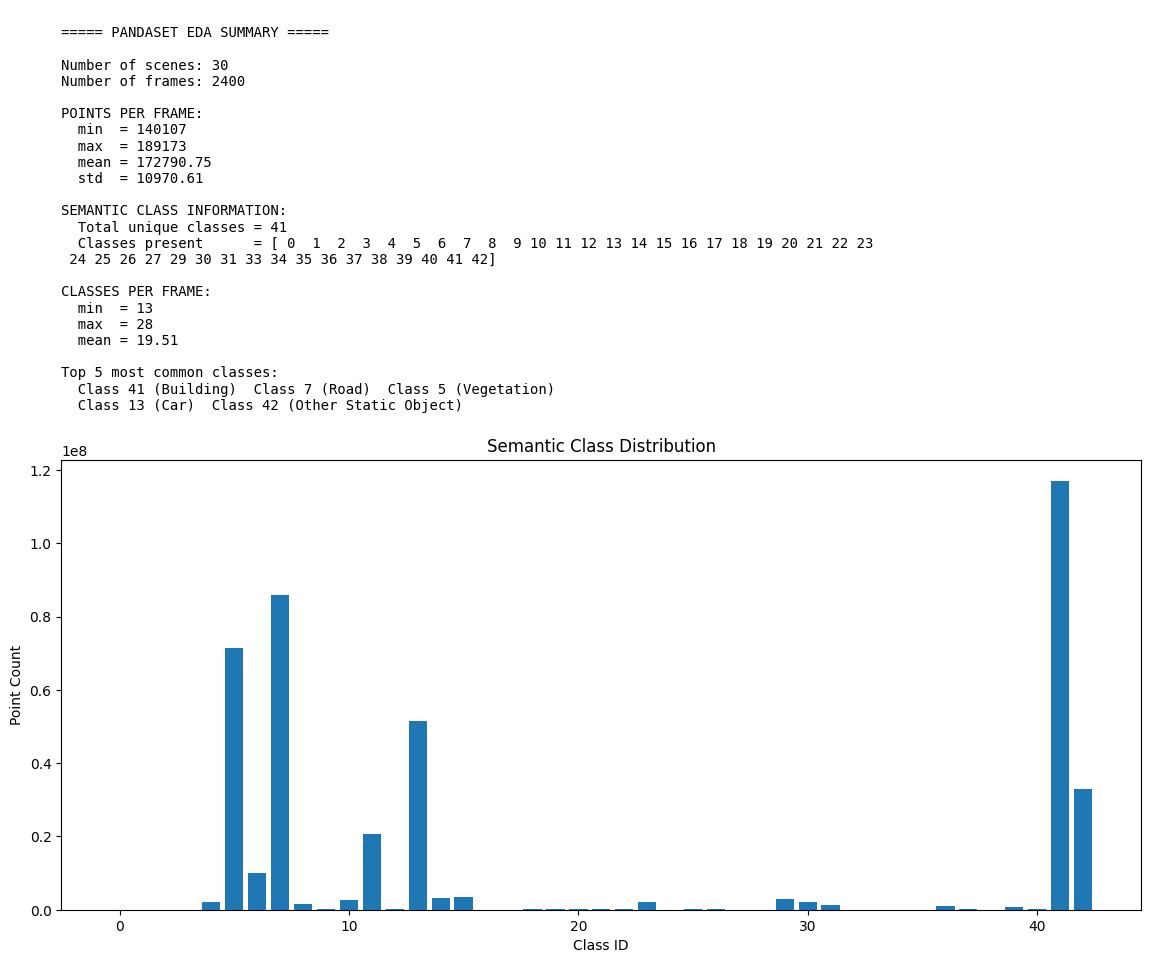

EDA complete!


In [7]:
run_eda(data, labels,class_map)

In [ ]:
# show pcds, image will pop up in windows, it may print out errors if the pop up windows are held for too long
show_pcd_example(data[0][10],poses[0][10],nb=20, std=3, voxel_size=0.05, radius=0.3, max_nn=30)

In [9]:
# Train test split on scene level
scene_ids = np.arange(len(lidar_data))

train_ids, test_ids = train_test_split(
    scene_ids,
    test_size=0.2,
    random_state=42,
    shuffle=True,
)

train_lidar  = [data[i] for i in train_ids]
train_labels = [labels[i] for i in train_ids]
train_poses  = [poses[i] for i in train_ids]

test_lidar   = [data[i] for i in test_ids]
test_labels  = [labels[i] for i in test_ids]
test_poses   = [poses[i] for i in test_ids]

print(f"Number of training scene:{len(train_lidar)}  Number of test scene:{len(test_lidar)}")


Number of training scene:24  Number of test scene:6


In [10]:
#wrap data in PointNeXtDataset
train_dataset = PointNeXtDataset(
        train_lidar,         # list[list[df]]
        train_labels,         # list[list[np.array]]
        train_poses,                # list[list[pose_dict]]
        num_points=16384,
        voxel_size=0.05,
        augment=True
    )
test_dataset  = PointNeXtDataset(
        test_lidar,         # list[list[df]]
        test_labels,         # list[list[np.array]]
        test_poses,                # list[list[pose_dict]]
        num_points=16384,
        voxel_size=0.05,
        augment=True
    )

In [11]:
from torch.utils.data import DataLoader

batch_size = 2  
# train loader and test loader
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    pin_memory=True,
    drop_last=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    pin_memory=True
)


In [12]:
# Check if the output is as expected
pts, labels = next(iter(train_loader))
print(pts.shape)


torch.Size([2, 16384, 4])


Using PointNeXt for Semantic Segmentation

Per the task requirements, we do not install PointNeXt in this environment, because:

The assignment focuses on pipeline design, not full training.

PointNeXt requires a Linux environment and CUDA = 11.3, which is not available here.

Training a full model is explicitly not required.

However, to demonstrate how the model would be used in practice, below is the correct installation procedure:

git clone https://github.com/guochengqian/PointNeXt.git

cd PointNeXt

source install.sh

install.sh builds CUDA kernels and must be updated if using a newer CUDA toolkit.

PointNeXt uses YAML configuration files. To adapt the architecture to our dataset, we modify the config in the yaml file:

cfg.model.encoder_args.in_channels = 4      # e.g., xyz + intensity 

cfg.model.cls_args.num_classes = 41          # number of semantic classes 

We can then build the model from the modified yaml file
  
model = build_model_from_cfg(cfg.model)
 

In [ ]:
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import ExponentialLR

#Training stub. For tasks in practice involving both training and evaluation, use k-fold cross validation

def train(model, train_loader, test_loader, num_epochs=100):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    # Set the optimizer, criterion,scheduler and hyperparameter
    criterion = nn.CrossEntropyLoss()

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    scheduler = torch.optim.lr_scheduler.StepLR(
        optimizer,
        step_size=2,
        gamma=0.97
    )

    for epoch in range(num_epochs):
        # Set modal to train mode
        model.train()
        loss_epoch = 0.0

        for pts, labels in train_loader:
            pts, labels = pts.to(device), labels.to(device)

            #Can be modified depends on what the model expects
            pts = pts.permute(0, 2, 1)  # (B, C, N)

            # Set gradient to zero before each batch
            optimizer.zero_grad()
            logits = model(pts)
            
            # reshape logits → (B*N, num_classes)
            logits = logits.permute(0, 2, 1).reshape(-1, logits.shape[1])

            labels = labels.reshape(-1)

            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()

            loss_epoch += loss.item()

        # Step the scheduler after epoch
        scheduler.step()

        print(f"Epoch {epoch+1}/{num_epochs} | "
              f"Loss: {loss_epoch:.4f} | "
              f"LR: {scheduler.get_last_lr()[0]:.6f}")
